# Telstra Network Disruptions

In [2]:
##############
# basic libs #
##############

import warnings
warnings.filterwarnings('ignore')
import os, sys, time, datetime, json, string, glob, re
from tqdm import *
from time import time

############
# plumbing #
############

from sqlalchemy import create_engine
from collections import OrderedDict
import urllib2, requests, operator, hashlib, uuid

###########
# science #
###########

from math import radians, cos, sin, asin, sqrt
from scipy import integrate, stats, interp
from scipy.spatial import distance
import numpy as np
import pandas as pd

#######
# ML #
######

import pymc3 as pm
import theano as thno
import theano.tensor as T
from sklearn import preprocessing
from sklearn import metrics
from sklearn import cross_validation
from sklearn import grid_search

#################
# visualization #
#################

from IPython.html.widgets import interactive, fixed
from mpl_toolkits.mplot3d import Axes3D

# plotly
import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go
import cufflinks as cf
cf.set_config_file(offline=False, world_readable=True, theme='pearl')
tls.set_credentials_file(username=os.environ.get('PLOTLY_USERNAME'), api_key=os.environ.get('PLOTLY_APIKEY'))

# matplotlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# seaborn
import seaborn as sns
sns.set(style="dark", palette="muted")
sns.set_context("notebook",
                font_scale=1.5,
                rc={"lines.linewidth": 2.5})

#graphistry
import graphistry
graphistry.register(key=os.environ.get('GRAPHISTRY_APIKEY'))

# pandas
#pd.set_option('display.mpl_style', 'default')
#pd.set_option('display.notebook_repr_html', True)

########
# data #
########

datadir = '/Users/cavagnolo/ml_fun/telstra/data/'
#datadir = '/home/kcavagnolo/ml_fun/telstra/data/'
files = sorted(glob.glob(datadir+'*.csv'))

# What's the problem?

* Informal: using Telstra's service logs, the task is to predict the severity of a network disruption.

* Describe the problem formally, e.g.
    * Task (T): For a specific time and location, classify network fault severity as 0 == no faults, 1 == few faults, 2 == many faults. Fault severity is a measurement of actual reported faults from users of the network and is the target variable.
    * Experience (E): Each row in the train/test data represents a location and a time point. They are identified by the "id" column, which is the key "id" used in the other data files (event_type, resource_type, severity_type, log_feature) that contain features extracted from log files and other sources. Note that severity_type:
        * Is a categorical feature extracted from the log files
        * "Often" (**when is it not?**) the type of the warning message coming from the log files
        * Does not have an ordering
    * Performance (P): Classification accuracy, the number of fault events predicted correctly (a set of predicted probabilities one for every fault severity mus be given) out of all faults considered as a percentage.

* Assumptions:
    * All given features will matter to the model.
    * The clustering in time and location matter to the model, but may be mutually exclusive.
    * The volume of faults may not matter to the model.
    * Systemic long duration, low-volume correlated faults could be hiding in data.

* Similar problems:
    * Airline loyalty and medallion class problem
    * Anomaly detection, e.g. [Twitter's R package](https://github.com/nicolasmiller/pyculiarity)

# How should I solve this problem?
* Brainstorm! Literally type everything as a stream of consciousness (coffee helps here)

These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts.

* Describe how to solve problem manually
* What data do I have?
* What data do I need?
* What data I **don't** need?
* What do I know the least about in the solution process above?
    * knowledge gap 1
    * knowledge gap 2
* What am I concerned is incorrect in above solution? Find an expert online and ask them about these items
    * concern 1
    * concern 2

# Data Preparation

## ETL

In [19]:
# go through each file and tell me what's in it
for f in files:
    df = pd.read_csv(f)
    cols = df.columns.tolist()
    obs = df.shape[0]
    print '{:15} {:s}'.format('Filename:', f)
    print '{:15} {:d}'.format('Observations:', obs)
    for c in cols:
        uflag = ""
        nflag = ""
        uni = len(pd.unique(df[c].ravel()))
        nulls = np.count_nonzero(df[c].isnull())
        if obs != uni:
            uflag = '*MULTIPLE VALS PER KEY*'
        if nulls >0 :
            nflag = '*NULLS IN COL*'
        print '{:15} {:d} {:20} {:20}'.format(c, uni, uflag, nflag)
    print '\n'

Filename:       /Users/cavagnolo/ml_fun/telstra/data/event_type.csv
Observations:   31170
id              18552 *MULTIPLE VALS PER KEY*                     
event_type      53 *MULTIPLE VALS PER KEY*                     


Filename:       /Users/cavagnolo/ml_fun/telstra/data/log_feature.csv
Observations:   58671
id              18552 *MULTIPLE VALS PER KEY*                     
log_feature     386 *MULTIPLE VALS PER KEY*                     
volume          9 *MULTIPLE VALS PER KEY*                     


Filename:       /Users/cavagnolo/ml_fun/telstra/data/resource_type.csv
Observations:   21076
id              18552 *MULTIPLE VALS PER KEY*                     
resource_type   10 *MULTIPLE VALS PER KEY*                     


Filename:       /Users/cavagnolo/ml_fun/telstra/data/severity_type.csv
Observations:   18552
id              18552                                          
severity_type   5 *MULTIPLE VALS PER KEY*                     


Filename:       /Users/cavagnolo/ml_fun/t

* Column names look fine, don't need to clean those
* No nulls, hooray
* Looks like each ID has only one severity type and multiple event types| log features| resource types:

For example, in the training set, consider ID 10005:

|id| item | code | sev/vol
|:-|:-|:-:|:-:
|10005 | location |802 | 0
|10005|severity_type |1|
|10005|event_type |11|
|10005|event_type |13|
|10005|event_type |14|
|10005|log_feature| 345|1
|10005|log_feature| 54|1
|10005|resource_type |4|
|10005|resource_type |6|
|10005|resource_type |8|

Transposing would be

|id|loc|sev|evt|fea|res
|-|
|10005|{802:0}|1|[11,13,14]|{54:1,345:1}|[4,6,8]

For a single id, the coding can't be a list, so one hot encode every type? How many are we talking?
* 53 event types (binary)
* 386 log features (continuous)
* 10 resource types (binary)

That's 449 features. Regardless, need to join all this data together. It's all categorical data (code_n is y/n), except for the log features which has a volume. What's the distribution and can data be re-binned into fewer values?

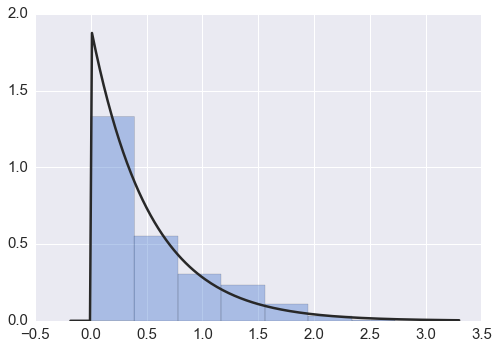

In [166]:
# one time analysis to re-bin volunme data
df = pd.read_csv(datadir+'log_feature_volume', index_col=0)
x = np.log10(df['volume'][(df.volume > 0)].values)
sns.distplot(x, bins=8, kde=False, fit=stats.expon)

# grab the bins in log space use the built-in Freedman-Diaconis rule
hist, bins = np.histogram(x, bins=8)

# assign each volume to a bin
inds = np.digitize(x, bins)

# add this to the df
df['volume'] = inds

**In hindsight**... Re-binning volumes into one-of-many categories didn't improve the models. Instead, the algos need a properly scaled volume (mean=0, std=1)...

In [208]:
# read raw volumes
df = pd.read_csv(datadir+'log_feature_volume')

# cleanup col names
for c in df.columns:
    if df[c].dtypes == 'object':
        df[c] = df[c].map(lambda x: re.sub("[^0-9]", "", x))
cnames = ['log_feature_'+str(x) for x in vols.columns]
        
# re-org by id        
vols = df.pivot(index='id', columns='log_feature', values='volume').fillna(0)

# scale
vols_scl = vols.apply(lambda x: preprocessing.StandardScaler().fit_transform(x))
vols_scl.columns = cnames

In [169]:
# join everything to train
df = pd.read_csv(files[5], index_col=0)
for c in df.columns:
    if df[c].dtypes == 'object':
        df[c] = df[c].map(lambda x: re.sub("[^0-9]", "", x))
df_train = df.copy()

# join everything to test
df = pd.read_csv(files[4], index_col=0)
for c in df.columns:
    if df[c].dtypes == 'object':
        df[c] = df[c].map(lambda x: re.sub("[^0-9]", "", x))
df_test = df.copy()

# add categorical event_type, resource_type, severity_type
nfiles = [files[0], files[2], files[3]]

# iterate over files
for f in nfiles:
    df = pd.read_csv(f, index_col=0)
    for c in df.columns:
        df[c] = df[c].map(lambda x: re.sub("[^0-9]", "", x))
    dfv = pd.get_dummies(df).groupby(df.index).sum()
    df_train = df_train.join(dfv)
    df_test = df_test.join(dfv)
    
# join scaled volumes
df_train = df_train.join(vols_scl)
df_test = df_test.join(vols_scl)

In [170]:
# gut check the 10005 entry from above
junk = df_train.T
x = junk.loc[:, 10005] > 0
x[x].index

Index([u'location', u'event_type_11', u'event_type_13', u'event_type_14',
       u'resource_type_4', u'resource_type_6', u'resource_type_8',
       u'severity_type_1', u'log_feature_345'],
      dtype='object')

In [171]:
# save to lrzipped hdf5 for easier loading later
df_test.to_hdf(datadir + 'test_features.h5', 'df')
df_train.to_hdf(datadir + 'train_features.h5', 'df')
#!lrzip -zf /home/kcavagnolo/ml_fun/telstra/data/test_features.h5
#!lrzip -zf /home/kcavagnolo/ml_fun/telstra/data/train_features.h5

# Reload starting point for future analysis

In [85]:
#!lrunzip -f /home/kcavagnolo/ml_fun/telstra/data/test_features.h5.lrz
#!lrunzip -f /home/kcavagnolo/ml_fun/telstra/data/train_features.h5.lrz
df_test = pd.HDFStore(datadir+'test_features.h5')['df']
df_train = pd.HDFStore(datadir+'train_features.h5')['df']
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

# Attribute Summaries

In [202]:
# items to plot
a = ['event_type', 'resource_type', 'severity_type']#, 'log_feature']

# build axes
mpl_fig = plt.figure()
ax1 = mpl_fig.add_subplot(311)
ax2 = mpl_fig.add_subplot(312)
ax3 = mpl_fig.add_subplot(313)
#ax4 = mpl_fig.add_subplot(414)
axs = [ax1, ax2, ax3]#, ax4]

# iterate over each
for i, b in enumerate(a):
    y = df_train.filter(regex=b).apply(pd.value_counts).fillna(0).T[1]
    y = 100.*(y/df.shape[0])
    x = range(1,len(y)+1)
    axs[i].bar(x, y, label=a[i])
    axs[i].set_ylabel(a[i])
py.iplot_mpl(mpl_fig, strip_style=True)

In [201]:
# build axes
mpl_fig = plt.figure()
ax1 = mpl_fig.add_subplot(311)
ax2 = mpl_fig.add_subplot(312)
ax3 = mpl_fig.add_subplot(313)
#ax4 = mpl_fig.add_subplot(414)
axs = [ax1, ax2, ax3]#, ax4]

# iterate over each
for i, b in enumerate(a):
    y = df_test.filter(regex=b).apply(pd.value_counts).fillna(0).T[1]
    y = 100.*(y/df.shape[0])
    x = range(1,len(y)+1)
    axs[i].bar(x, y, label=a[i])
    axs[i].set_ylabel(a[i])
py.iplot_mpl(mpl_fig, strip_style=True)

Distributions looks similar, so train will cv w/ test. Any structure in sequence of ID's?

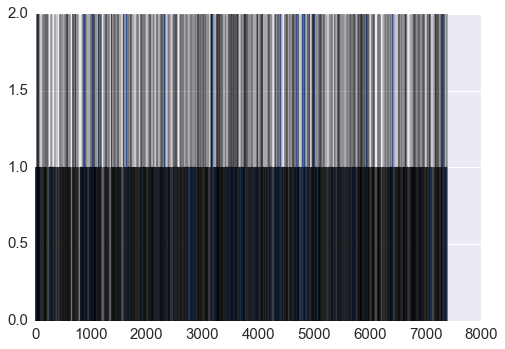

In [205]:
fault = df_train.fault_severity.astype(float)
n = len(fault)
plt.bar(np.arange(n), fault)
plt.show()

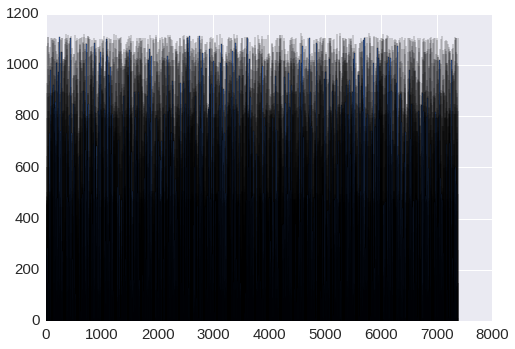

In [225]:
loc = df_train.location.astype(float)
plt.bar(np.arange(n), loc)
plt.show()

Both look like noise to me, gonna leave it for now. What about correlations among the various codes?

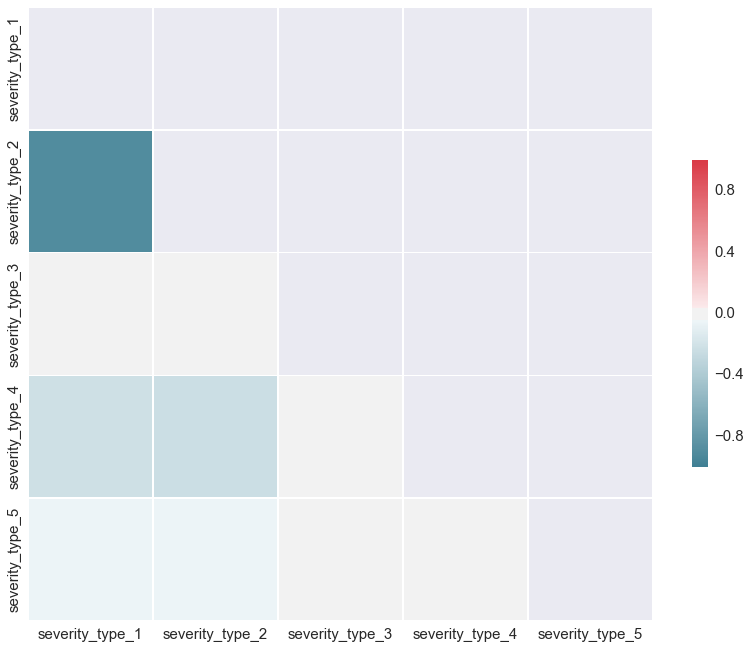

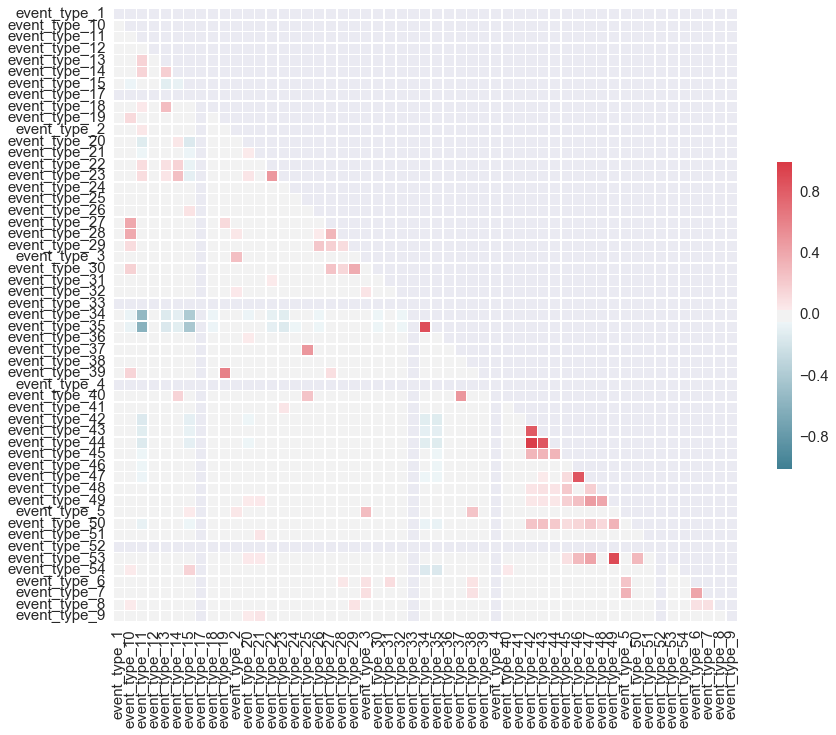

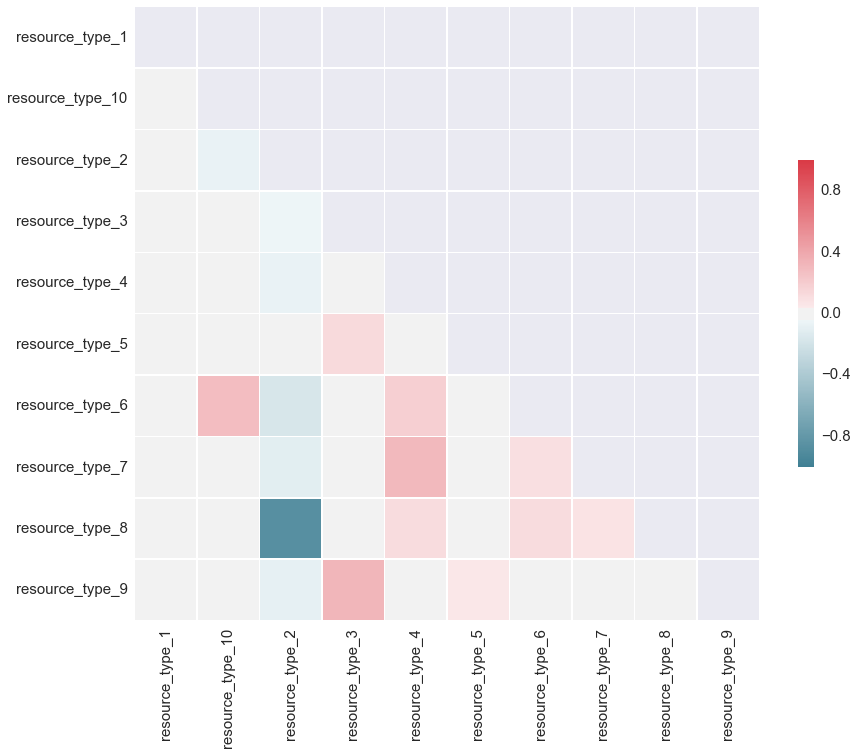

In [214]:
a = ['severity_type', 'event_type', 'resource_type']
for b in a:

    # Compute the correlation matrix
    corr = df_train.filter(regex=b).corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(14, 11))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

The serverity types are anti-correlated as expected, and there is interesting structure in the resource and event types. Makes me more curious about how these events are networked, i.e. communicating to each other? Build out as network problem? Can't: id and loc are 1:1 so the only connections will be among events that are the same, in that they have the same coding across all types. I don't see that as informative to a model.

# Feature Engineering

* Data has complex multi-dimensional structures that ML algos know how to find and exploit to make decisions
* You want to best expose those structures to the algo
* Some structures may be too dense or too complex for the algo to find without help (domain expertise comes into play here)
* Attribute decomposition into simpler components
* Attribute aggregation, e.g. hyperattributes

In [166]:
# master feature and target objects
y = df_train['fault_severity']
X = df_train.copy().drop('location', 1).drop('fault_severity', 1).drop('id', 1)

## Dimension Reduction and Clustering

However, clustering should be interesting: can add cluster membership as a new feature. Data is sparse matrix of binary and multiclass values, options for analysis:
* [PCA or SVD](http://blog.applied.ai/visualising-high-dimensional-data/)
* [t-SNE](https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm)
* [Binary Jaccard similarity matrix fed into hierarchical cluster and then using the top "nodes"](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_similarity_score.html)
* K-mode/median clustering
* [Cosine similarities fed into spectral clustering or dbscan](http://stackoverflow.com/questions/30089675/clustering-cosine-similarity-matrix)
* Frequent itemset mining

For k-means, see the odot ipynb, which isn't relevant here since this is categorical data (0/1) and Euclidean distance (used for clustering in k-menas) will be meaningless.

**In hindsight...** Location really fucks with the analysis. It appears to be meaningless, so I'm dumping it.

## SVD

How many components in the full dataset to preserve? Look at SVD...

Variance preserved at 140 components == 91.5%
Variance preserved at 160 components == 94.4%
Variance preserved at 180 components == 96.5%
Variance preserved at 200 components == 97.9%
Variance preserved at 220 components == 98.9%
Variance preserved at 240 components == 99.5%
Variance preserved at 260 components == 99.8%
Variance preserved at 280 components == 99.9%
Variance preserved at 300 components == 100.0%
Variance preserved at 320 components == 100.0%


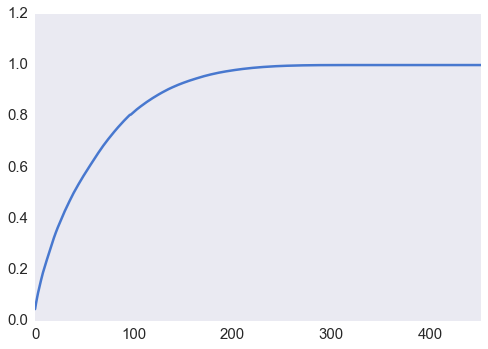

In [167]:
from sklearn.decomposition import TruncatedSVD
ncomps = X.shape[1]-1
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(X)
for i in range(0, X.shape[1], 20):
    svar = svd_fit.explained_variance_ratio_.cumsum()[i]
    if svar >= 0.9 and svar <= 1:
        print('Variance preserved at {:} components == {:.1%}'.format(i, svar))
ax = pd.Series(svd_fit.explained_variance_ratio_.cumsum()).plot(kind='line')

At 200 components 98% of variance is preserved, so try keeping just those in a new df.

In [168]:
ncomps = 200
X_svd = TruncatedSVD(n_components=ncomps).fit_transform(X)
dfsvd = pd.DataFrame(X_svd, columns=['c{}'.format(c) for c in range(ncomps)], index=df_train.index)
svdcols = [c for c in dfsvd.columns if c[0] == 'c']

## t-SNE

In [ ]:
# check for struc in tsne
from sklearn.manifold import TSNE
metric = metrics.pairwise.manhattan_distances
tsne = TSNE(n_components=2, init='pca',
            perplexity=50, #metric=metric,
            learning_rate=500, method='barnes_hut',
            verbose=2)
Z = tsne.fit_transform(dfsvd[svdcols])
dftsne = pd.DataFrame(Z, columns=['x','y'], index=dfsvd.index)
dftsne['fault_severity'] = df_train['fault_severity']

In [84]:
# plot the result
mpl_fig = plt.figure()
sns.regplot(dftsne['x'],
            dftsne['y'],
           fit_reg=False,
           scatter=True,
           scatter_kws={"c": dftsne['fault_severity'],
                        "cmap": plt.cm.jet,
                        "label": dftsne['fault_severity']}
           )
plt.title('t-SNE')
plt.xlabel('p1')
plt.ylabel('p2')
py.iplot_mpl(mpl_fig, strip_style=True)

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
from scipy.spatial.distance import squareform, pdist


def _joint_probabilities_constant_sigma(D, sigma):
    P = np.exp(-D**2/2 * sigma**2)
    P /= np.sum(P, axis=1)
    return P

# Pairwise distances between all data points.
D = pairwise_distances(dfsvd[svdcols], squared=True)

# Similarity with constant sigma.
P_constant = _joint_probabilities_constant_sigma(D, .002)

# Similarity with variable sigma.
P_binary = _joint_probabilities(D, 30., False)

# The output of this function needs to be reshaped to a square matrix.
P_binary_s = squareform(P_binary)

In [122]:
def factors(n):    
    return set(reduce(list.__add__, 
                ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))

factors(D.shape[0])

{1, 11, 61, 121, 671, 7381}

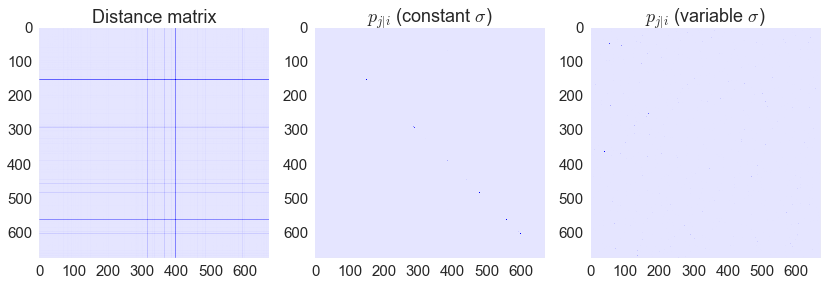

In [130]:
plt.figure(figsize=(14, 11))
pal = sns.light_palette("blue", as_cmap=True)

binning = 11

plt.subplot(131)
plt.imshow(D[::binning, ::binning], interpolation='none', cmap=pal)
plt.title("Distance matrix")

plt.subplot(132)
plt.imshow(P_constant[::binning, ::binning], interpolation='none', cmap=pal)
plt.title("$p_{j|i}$ (constant $\sigma$)")

plt.subplot(133)
plt.imshow(P_binary_s[::binning, ::binning], interpolation='none', cmap=pal)
plt.title("$p_{j|i}$ (variable $\sigma$)")

This... is not obvious. But the clustering of high fault events looks clearer without location.

In [136]:
# This list will contain the positions of the map points at every iteration.
positions = []
def _gradient_descent(objective, p0, it, n_iter, n_iter_without_progress=30,
                      momentum=0.5, learning_rate=1000.0, min_gain=0.01,
                      min_grad_norm=1e-7, min_error_diff=1e-7, verbose=0,
                      args=[]):
    # The documentation of this function can be found in scikit-learn's code.
    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = 0

    for i in range(it, n_iter):
        # We save the current position.
        positions.append(p.copy())

        new_error, grad = objective(p, *args)
        error_diff = np.abs(new_error - error)
        error = new_error
        grad_norm = linalg.norm(grad)

        if error < best_error:
            best_error = error
            best_iter = i
        elif i - best_iter > n_iter_without_progress:
            break
        if min_grad_norm >= grad_norm:
            break
        if min_error_diff >= error_diff:
            break

        inc = update * grad >= 0.0
        dec = np.invert(inc)
        gains[inc] += 0.05
        gains[dec] *= 0.95
        np.clip(gains, min_gain, np.inf)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

    return p, error, i
import sklearn
sklearn.manifold.t_sne._gradient_descent = _gradient_descent
from numpy import linalg
from numpy.linalg import norm

In [140]:
X_proj = TSNE().fit_transform(dfsvd[svdcols[:3]])

In [141]:
X_iter = np.dstack(position.reshape(-1, 2)
                   for position in positions)

In [156]:
import matplotlib.patheffects as PathEffects

def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(3):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [ ]:
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

f, ax, sc, txts = scatter(X_iter[..., -1], y)

def make_frame_mpl(t):
    i = int(t*40)
    x = X_iter[..., i]
    sc.set_offsets(x)
    for j, txt in zip(range(3), txts):
        xtext, ytext = np.median(x[y == j, :], axis=0)
        txt.set_x(xtext)
        txt.set_y(ytext)
    return mplfig_to_npimage(f)

animation = mpy.VideoClip(make_frame_mpl,
                          duration=X_iter.shape[2]/40.)
animation.write_gif("junk.gif", fps=20)

In [ ]:
n = 1. / (pdist(X_iter[..., -1], "sqeuclidean") + 1)
Q = n / (2.0 * np.sum(n))
Q = squareform(Q)

f = plt.figure(figsize=(6, 6))
ax = plt.subplot(aspect='equal')
im = ax.imshow(Q, interpolation='none', cmap=pal)
plt.axis('tight')
plt.axis('off')

def make_frame_mpl(t):
    i = int(t*40)
    n = 1. / (pdist(X_iter[..., i], "sqeuclidean") + 1)
    Q = n / (2.0 * np.sum(n))
    Q = squareform(Q)
    im.set_data(Q)
    return mplfig_to_npimage(f)

animation = mpy.VideoClip(make_frame_mpl,
                          duration=X_iter.shape[2]/121.)
animation.write_gif("junk2.gif", fps=20)

## Cosine Similarity and DBScan

In [9]:
# remove the log_feature features which are scaled volumes
ecols = [c for c in X.columns if 'log_feature' not in c]
X_c = X.copy()
X_c = X_c[ecols]

In [10]:
# base similarity matrix
similarity = np.dot(X_c, X_c.T)

# squared magnitude of preference vectors (number of occurrences)
square_mag = np.diag(similarity)

# inverse squared magnitude
inv_square_mag = 1 / square_mag

# if it doesn't occur, set it's inverse magnitude to zero (instead of inf)
inv_square_mag[np.isinf(inv_square_mag)] = 0

# inverse of the magnitude
inv_mag = np.sqrt(inv_square_mag)

# cosine similarity
cosine = similarity * inv_mag
cosine = cosine.T * inv_mag

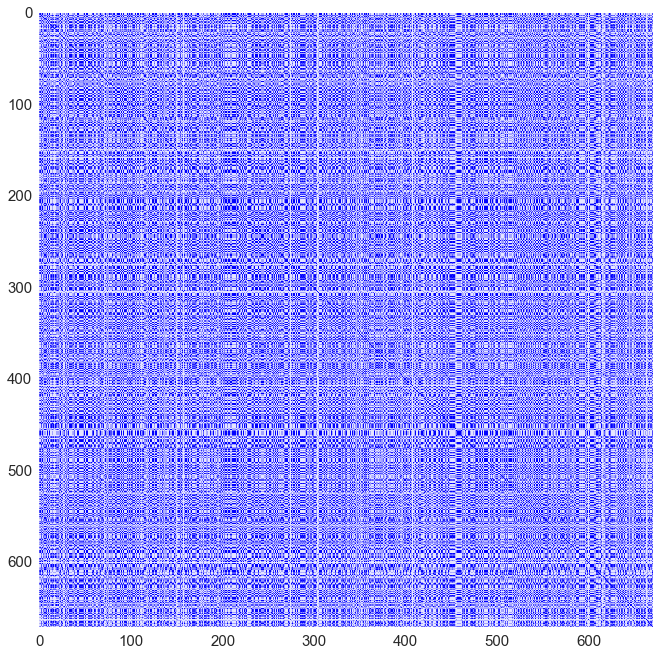

In [11]:
# plot it
plt.figure(figsize=(14, 11))
cmap = sns.light_palette("blue", as_cmap=True)
binning = 11
plt.imshow(cosine[::binning, ::binning], interpolation='none', cmap=cmap)

In [12]:
from sklearn.cluster import DBSCAN
dbclust = DBSCAN(min_samples=30, eps=0.6).fit_predict(1.0-cosine)

(0, 2143)
(1, 647)
(2, 1239)
(3, 32)
(4, 38)
(5, 140)
(6, 52)
(7, 43)
(8, 347)
(9, 239)
(10, 30)
(11, 855)
(12, 206)
(13, 81)
(14, 30)
(15, 31)
(16, 32)
(17, 82)
(18, 45)
(19, 117)
(20, 49)
(21, 39)
(22, 36)
(-1, 828)


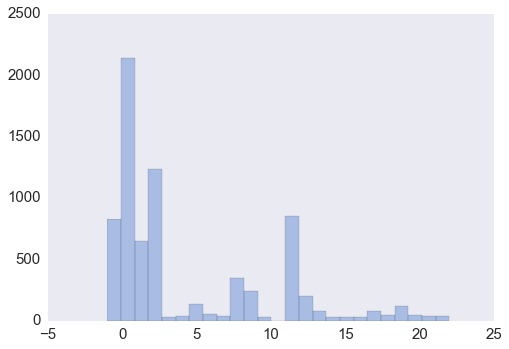

In [13]:
# viz the cluster dist
from collections import Counter
for i in Counter(dbclust).items():
    print i
sns.distplot(dbclust, kde=False)

## K-modes

In [ ]:
# save X, y, and feature names w and w/o loc and fault sev
y      = df_train.fault_severity.as_matrix()
fea_nl = df_train.copy().drop('fault_severity', axis=1).drop('location', 1).columns
X_nl   = df_train.copy().drop('location', 1).as_matrix().astype(np.float)

# checks
print "%d observations of %d features (orig)" % df_train.shape
print "%d observations of %d features (-fsev)" % X_l.shape
print "%d observations of %d features (-fsev -loc)" % X_nl.shape
print "Unique labels:", np.unique(y)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2579, cost: 29924.0
Run 1, iteration: 2/100, moves: 265, cost: 29496.0
Run 1, iteration: 3/100, moves: 91, cost: 29449.0
Run 1, iteration: 4/100, moves: 6, cost: 29449.0
(0, 3682)
(1, 3)
(2, 25)
(3, 32)
(4, 2)
(5, 232)
(6, 44)
(7, 1)
(8, 182)
(9, 23)
(10, 3)
(11, 175)
(12, 49)
(13, 236)
(14, 1990)
(15, 257)
(16, 286)
(17, 2)
(18, 10)
(19, 147)


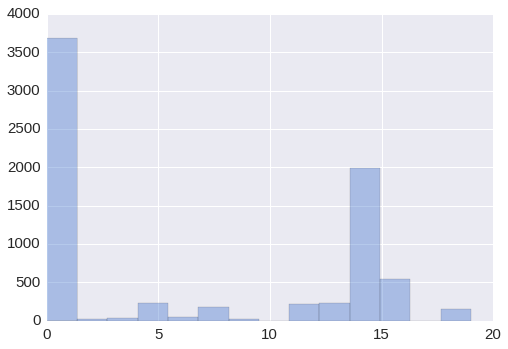

In [315]:
from kmodes import kmodes

# build the clusters
km = kmodes.KModes(n_clusters=20, init='Cao', n_init=5, verbose=1)
clusters = km.fit_predict(X_nl)

# viz the cluster dist
for i in Counter(clusters).items():
    print i
sns.distplot(clusters, kde=False)

That's not a terrible result, it somewhat mimics the tsne result, except for bins 3 and 4, as I don't see any isolated points in tsne, but it's not a 1:1 comparison. Let's see how this performs. First add the cluster assignments to the X matrix.

In [111]:
# append cluster membership to the no-location version of X
a = np.array(clusters)[np.newaxis]
print 'X no loc ', X_nl.shape
X_nlc = np.concatenate((X_nl, a.T), axis=1)
print 'X no loc+clu ', X_nlc.shape

X no loc  (7381, 454)
X no loc+clu  (7381, 455)


# Algorithm Evaluation

## Theano

In [ ]:
#quick existing model test
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
thno.config.compute_test_value = 'warn'

# common vars
batch_size = 128
nb_epoch = 20
dims = X.shape[1]

# rebuild the train and test sets
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
Y_train = np_utils.to_categorical(y_train, 3)
Y_test = np_utils.to_categorical(y_test, 3)

# NN model and layers
model = Sequential()
model.add(Dense(512, input_shape=(dims,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(3))
model.add(Activation('softmax'))
rms = RMSprop()
model.compile(loss='categorical_crossentropy', optimizer=rms)

# fit the model
model.fit(X_train, Y_train,
          batch_size=batch_size,
          nb_epoch=nb_epoch,
          show_accuracy=True,
          verbose=2,
          validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test,
                       show_accuracy=True,
                       verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

## Scikit

Going to build test harness of test, train, and validation splits using KFolding. Then run predicitions for each fold. Also want to keep track of true positive rate (tpr) and false positive rate (fpr) so I can evaluate receiving operating characteristic curves (ROC's) and the associated area under the curve (AUC) of each. I will also plot the confusion matrix for each model to visualize the predicitve results.

Define the cross-validation and confusion matrix helper functions.

In [126]:
# build a cross-validation function
def run_cv(X, y, clf_class, **kwargs):
    kf = cross_validation.KFold(len(y), n_folds=10, shuffle=True)
    y_pred = y.copy()
    mean_acc = 0.0
    mean_prec = 0.0
    mean_recl = 0.0
    mean_f1 = 0.0
    for train_index, test_index in kf:
        clf = clf_class(**kwargs)
        X_train, X_test = X.ix[train_index], X.ix[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_pred[test_index] = clf.predict(X_test)
        mean_acc += metrics.accuracy_score(y[test_index], y_pred[test_index])
        mean_recl += metrics.recall_score(y[test_index], y_pred[test_index])
        mean_prec += metrics.precision_score(y[test_index], y_pred[test_index])
        mean_f1 += metrics.f1_score(y[test_index], y_pred[test_index])
    mean_acc /= len(kf)
    mean_recl /= len(kf)
    mean_prec /= len(kf)
    mean_f1 /= len(kf)
    return y_pred, mean_acc, mean_prec, mean_recl, mean_f1

def draw_confusion_matrices(confusion_matrices, class_names):
    labels = list(class_names)
    for cm in confusion_matrices:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm[1])
        fig.colorbar(cax)
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)
        plt.title('%s' % cm[0])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        for i,j in ((x,y) for x in xrange(len(cm[1])) for y in xrange(len(cm[1][0]))):
            val = '{:.1%}'.format(cm[1][i][j]/cm[1].sum())
            ax.annotate(str(val), xy=(i,j), color='white', ha="center", va="center")
        plt.show()

Loading up a bunch of standard machine learning algorithms into test harness. This is a classification problem, so let's try the standard models...

In [127]:
from xgboost import XGBClassifier as XGBC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF

ml_models = []
#ml_models.append(["XGBoost", XGBC, {'max_depth':3,
#                                    'n_estimators':300,
#                                    'learning_rate':0.05,
#                                    'verbose':1}])
#ml_models.append(["Support Vector", SVC, {'verbose':1}])
#ml_models.append(["Logistic Regression", LR, {'multi_class':'multinomial',
#                                              'solver':'lbfgs',
#                                              'verbose':1}])
#ml_models.append(["Naive Bayes", NB, {'verbose':1}])
#ml_models.append(["Decision Trees", DT, {'verbose':1}])
ml_models.append(["Random Forest", RF, {'n_estimators':200,
                                        'min_samples_split':2,
                                        'n_jobs':-1,
                                        'verbose':1}])

### Measure Performance

Show me the accuracy (acc), precision (prec), recall (recl), confusion matrix (cm), and mean auc for each model.

Gut check accuravy vs the jaccard similarity (should be equivalent):
```python
metrics.jaccard_similarity_score(y_true, y_pred)
```

[Parallel(n_jobs=-1)]: Done   1 out of 200 | elapsed:    0.1s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Done   1 out of  53 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass

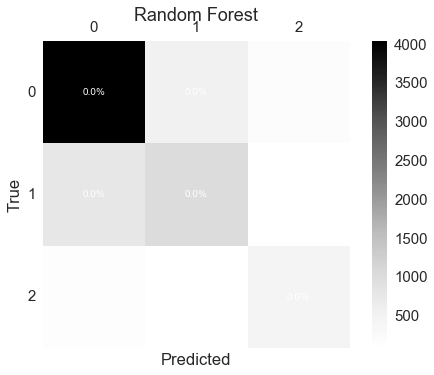

In [128]:
# process each model
models = []
acc = []
prec = []
recl = []
f1 = []
cms = []
for m in ml_models:
    y_pred, mean_acc, mean_prec, mean_recl, mean_f1 = run_cv(X, y, m[1], **m[2])
    models.append(m[0])
    acc.append(mean_acc)
    prec.append(mean_prec)
    recl.append(mean_recl)
    f1.append(mean_f1)
    cms.append((m[0], metrics.confusion_matrix(y, y_pred)))

# plot confusion matricies
draw_confusion_matrices(cms, np.unique(y))

In [129]:
models_df = pd.DataFrame.from_items([('model', models),
                              ('accuracy', acc),
                              ('precision', prec),
                              ('recall', recl),
                              ('f1', f1)
                              ])
models_df.sort(['accuracy', 'precision', 'recall', 'f1'], ascending=[False, False, False, False])

,model,accuracy,precision,recall,f1
0,Random Forest,0.746648,0.741674,0.746648,0.743129


### Testing Results

Find which of the harness models has performed the best in the first pass.

In [130]:
# best and worst models
max_idx, max_value = max(enumerate(acc), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best accuracy:', ml_models[max_idx][0], acc[max_idx])

max_idx, max_value = max(enumerate(prec), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best precision:', ml_models[max_idx][0], prec[max_idx])

max_idx, max_value = max(enumerate(recl), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best recall:', ml_models[max_idx][0], recl[max_idx])

Best accuracy:       Random Forest        74.66%
Best precision:      Random Forest        74.17%
Best recall:         Random Forest        74.66%


In [165]:
rfc = RandomForestClassifier(n_estimators=72, min_samples_split=9)
rfc.fit(X, y)

test = df_test.copy().drop('location', 1).drop('id', 1)
prob = rfc.predict_proba(test)

rfc_res = pd.DataFrame({
    'id': df_test.loc[:, 'id'].values, 
    'predict_0': prob[:, 0],
    'predict_1': prob[:, 1],
    'predict_2': prob[:, 2]})

rfc_res.to_csv('randomforest.csv', index=False)

Random forest is the obvious winner by all measures, so let's take a crack at tuning that model.

## Algorithm Tuning

### Question: What are the important features in the model, and does the model improve when using those features only?

In [131]:
# feature importance
kf = cross_validation.KFold(len(y), n_folds=10, shuffle=True, random_state=4)
y_pred = y.copy()

# keep values for all features
feat_impt = {}
for f in features:
    feat_impt[f] = []

# go through all features    
for train_index, test_index in kf:
    clf = RF(n_estimators=50, min_samples_split=2, n_jobs=-1)
    X_train, X_test = X.ix[train_index], X.ix[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    y_pred[test_index] = clf.predict(X_test)
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    for f in range(X.shape[1]):
        feat_impt[features[indices[f]]].append(importances[indices[f]])

for k in feat_impt:
    val = np.mean(feat_impt[k])
    std = np.std(feat_impt[k])
    feat_impt[k] = val

In [133]:
# sort the features by importance
sorted_feat = sorted(feat_impt.items(), key=operator.itemgetter(1))
sorted_feat.reverse()

# bookkeeping
cumper = 0.
nbr = False

# make a copy of original dataframe to drop unneeded features
X_keep = X.copy()

# print out importances
print "item -- feature -- weight -- cumm_weight"
for i, k in enumerate(sorted_feat):
    cumper += k[1]
    
    # tell me when we hit 90% of weights
    if (nbr is False and cumper >= 0.95):
        print '**----  Reached 95%  ----**'
        nbr = True
    print i, k[0], '{:.1%}'.format(k[1]), '{:.0%}'.format(cumper)
    
    # drop unneeded features
    if nbr is True:
        X_keep = X_keep.drop(k[0], axis=1)

item -- feature -- weight -- cumm_weight
0 log_feature_202 14.5% 15%
1 log_feature_81 10.3% 25%
2 log_feature_17 3.7% 29%
3 log_feature_311 3.1% 32%
4 log_feature_53 2.8% 34%
5 log_feature_231 2.3% 37%
6 log_feature_70 2.3% 39%
7 log_feature_8 2.3% 41%
8 log_feature_67 1.9% 43%
9 log_feature_200 1.7% 45%
10 log_feature_192 1.7% 47%
11 event_type_14 1.4% 48%
12 resource_type_9 1.4% 50%
13 event_type_34 1.3% 51%
14 log_feature_72 1.3% 52%
15 log_feature_312 1.2% 53%
16 resource_type_10 1.2% 54%
17 log_feature_306 1.1% 56%
18 log_feature_232 1.0% 57%
19 resource_type_7 1.0% 58%
20 severity_type_1 1.0% 59%
21 log_feature_226 0.9% 59%
22 log_feature_194 0.9% 60%
23 log_feature_170 0.9% 61%
24 event_type_10 0.8% 62%
25 log_feature_314 0.8% 63%
26 event_type_33 0.8% 64%
27 log_feature_54 0.8% 64%
28 log_feature_272 0.8% 65%
29 log_feature_201 0.7% 66%
30 log_feature_208 0.7% 67%
31 log_feature_300 0.7% 67%
32 log_feature_290 0.6% 68%
33 log_feature_282 0.6% 69%
34 log_feature_367 0.6% 69%
35 

In [136]:
features_keep = X_keep.columns

# checks
print "\n%d observations of %d features" % X_keep.shape
print "Unique labels:", np.unique(y)
print "Gut-check features: %i" % len(features_keep)


7381 observations of 454 features
Unique labels: [0 1 2]
Gut-check features: 454


Re-run the ML test harness for RF only and see if the model improves (below is cut and paste of earlier code)

/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/usr/local/lib/python2.7/site-packages/sklearn/m

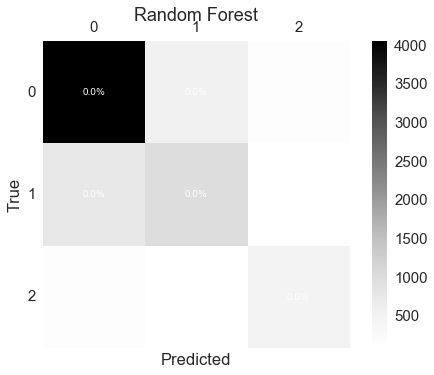

Best accuracy:       Random Forest        74.94%
Best precision:      Random Forest        74.44%
Best recall:         Random Forest        74.94%


In [137]:
ml_models = []
ml_models.append(["Random Forest", RF, {'n_estimators':72,
                                        'min_samples_split':9,
                                        'n_jobs':-1}])
acc = []
prec = []
recl = []
f1 = []
cms = []
for m in ml_models:
    y_pred, mean_acc, mean_prec, mean_recl, mean_f1 = run_cv(X_keep, y, m[1], **m[2])
    acc.append(mean_acc)
    prec.append(mean_prec)
    recl.append(mean_recl)
    f1.append(mean_f1)
    cms.append((m[0], metrics.confusion_matrix(y, y_pred)))

draw_confusion_matrices(cms, np.unique(y))
max_idx, max_value = max(enumerate(acc), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best accuracy:', ml_models[max_idx][0], acc[max_idx])
max_idx, max_value = max(enumerate(prec), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best precision:', ml_models[max_idx][0], prec[max_idx])
max_idx, max_value = max(enumerate(recl), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best recall:', ml_models[max_idx][0], recl[max_idx])

* RF predictive power got worse when features contributing < 10% weight were dropped.
* **RF predictive power got better when features contributing < 5% weight were dropped.**

### Question: But is RF superior in its calibration and discrimination?

Calibration measures the difference between actual and predicted probability for individual groups. Discrimination measures the difference between model predictions and the baseline probability. Equations are taken from [Yang, Yates, and Smith (1991)](http://psychology.huji.ac.il/.upload/Ilan/YanivYatesSmith1991PB.pdf).

In [140]:
def run_prob_cv(X, y, clf_class, **kwargs):
    kf = cross_validation.KFold(len(y), n_folds=10, shuffle=True)
    y_prob = np.zeros((len(y), 3))
    for train_index, test_index in kf:
        clf = clf_class(**kwargs)
        X_train, X_test = X.ix[train_index], X.ix[test_index]
        y_train = y[train_index]
        clf.fit(X_train,y_train)
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob

def calibration(prob, outcome,n_bins=10):
    prob = np.array(prob)
    outcome = np.array(outcome)
    c = 0.0
    judgement_bins = np.arange(n_bins + 1) / n_bins
    bin_num = np.digitize(prob,judgement_bins)
    for j_bin in np.unique(bin_num):
        in_bin = bin_num == j_bin
        predicted_prob = np.mean(prob[in_bin])
        true_bin_prob = np.mean(outcome[in_bin])
        c += np.sum(in_bin) * ((predicted_prob - true_bin_prob) ** 2)
    return c / len(prob)

def discrimination(prob, outcome, n_bins=10):
    prob = np.array(prob)
    outcome = np.array(outcome)
    d = 0.0
    base_prob = np.mean(outcome)
    judgement_bins = np.arange(n_bins + 1) / n_bins
    bin_num = np.digitize(prob,judgement_bins)
    for j_bin in np.unique(bin_num):
        in_bin = bin_num == j_bin
        true_bin_prob = np.mean(outcome[in_bin])
        d += np.sum(in_bin) * ((true_bin_prob - base_prob) ** 2)
    return d / len(prob)

In [141]:
print "Lower calibration and higher discrimination are preferred..."

ml_models = []
#ml_models.append(["XGBoost", XGBC, {'max_depth':3, 'n_estimators':300, 'learning_rate':0.05}])
#ml_models.append(["Support Vector Machine", SVC, {}])
ml_models.append(["Linear Logistic Regression", LR, {'multi_class':'multinomial',
                                                     'solver':'lbfgs'}])
ml_models.append(["Naive Bayes", NB, {}])
ml_models.append(["Decision Trees", DT, {}])
ml_models.append(["Random Forest", RF, {'n_estimators':200,
                                        'min_samples_split':2, 'n_jobs':-1}])

cal_err = []
discrim = []
for m in ml_models:
    print "\n"+m[0]
    pred_prob = run_prob_cv(X, y, m[1], **m[2])
    churn_prob, is_churn = pred_prob[:,1], y == 1
    cal_err.append(calibration(churn_prob, is_churn))
    discrim.append(discrimination(churn_prob,is_churn))
    print '{:20} {:.4f}'.format("Calibration Error", cal_err[-1])
    print '{:20} {:.4f}'.format("Discrimination", discrim[-1])
    
idx, value = min(enumerate(cal_err), key=operator.itemgetter(1))
print '{:20} {:20} {:.3%}'.format('\nBest calibration error:', ml_models[idx][0], cal_err[idx])
idx, value = max(enumerate(discrim), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best discrimination:', ml_models[idx][0], discrim[idx])

Lower calibration and higher discrimination are preferred...

Linear Logistic Regression
Calibration Error    0.0140
Discrimination       0.0000

Naive Bayes
Calibration Error    0.2666
Discrimination       0.0008

Decision Trees
Calibration Error    0.0399
Discrimination       0.0145

Random Forest
Calibration Error    0.0003
Discrimination       0.0015

Best calibration error: Random Forest        0.032%
Best discrimination: Decision Trees       1.45%


### Question: Can we tune the model params to get better results?

In [235]:
from operator import itemgetter

def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [ ]:
clf = RF(n_jobs=-1)
param_grid = {"n_estimators":[50, 75, 100],
              "max_depth": [None, 3],
              "max_features": [None, 'auto'],
              "min_samples_split": [4, 9],
              "min_samples_leaf": [1],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
gs = grid_search.GridSearchCV(clf, param_grid=param_grid)
start = time()
gs.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(gs.grid_scores_)))
report(grid_search.grid_scores_)

**Best scores using X (took 542.40 seconds for 32 candidate parameter settings):**

Model with rank: 1
Mean validation score: 0.956 (std: 0.007)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

Model with rank: 2
Mean validation score: 0.956 (std: 0.009)
Parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 1000, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

Model with rank: 3
Mean validation score: 0.955 (std: 0.006)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 1000, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}


**Best scores using X_keep (took 471.68 seconds for 48 candidate parameter settings):**

Model with rank: 1
Mean validation score: 0.957 (std: 0.007)
Parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 1000, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

Model with rank: 2
Mean validation score: 0.956 (std: 0.006)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

Model with rank: 3
Mean validation score: 0.956 (std: 0.007)
Parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 50, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

In [ ]:
ml_models = []
ml_models.append(["Random Forest", RF, {'bootstrap': True,
                                        'min_samples_leaf': 1,
                                        'n_estimators': 500,
                                        'min_samples_split': 4,
                                        'criterion': 'entropy',
                                        'max_features': 'auto',
                                        'max_depth': None,
                                        'n_jobs': -1}])
acc = []
prec = []
recl = []
f1 = []
cms = []
for m in ml_models:
    y_pred, mean_acc, mean_prec, mean_recl, mean_f1 = run_cv(X, y, m[1], **m[2])
    acc.append(mean_acc)
    prec.append(mean_prec)
    recl.append(mean_recl)
    f1.append(mean_f1)
    cms.append((m[0], metrics.confusion_matrix(y, y_pred)))
draw_confusion_matrices(cms, np.unique(y))
max_idx, max_value = max(enumerate(acc), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best accuracy:', ml_models[max_idx][0], acc[max_idx])
max_idx, max_value = max(enumerate(prec), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best precision:', ml_models[max_idx][0], prec[max_idx])
max_idx, max_value = max(enumerate(recl), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best recall:', ml_models[max_idx][0], recl[max_idx])

**This model is hardly better than the initial guess, but it's technically simpler, so I'll run with this one.**

In [ ]:
# Use 10 estimators so predictions are all multiples of 0.1
m = (["Random Forest", RF, {'bootstrap': True,
                            'min_samples_leaf': 1,
                            'n_estimators': 10,
                            'min_samples_split': 1,
                            'criterion': 'entropy',
                            'max_features': 'auto',
                            'max_depth': None,
                            'n_jobs': -1}])
pred_prob = run_prob_cv(X, y, m[1], **m[2])
pred_churn = pred_prob[:,1]
is_churn = y == 1

# Number of times a predicted probability is assigned to an observation
counts = pd.value_counts(pred_churn)

# calculate true probabilities
true_prob = {}
for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[pred_churn == prob])
    true_prob = pd.Series(true_prob)

# pandas-fu
counts = pd.concat([counts,true_prob], axis=1).reset_index()
counts.columns = ['pred_prob', 'count', 'true_prob']
counts

In [ ]:
from ggplot import *
baseline = np.mean(is_churn)
ggplot(counts, aes(x='pred_prob',y='true_prob',size='count')) + \
        geom_point(color='blue') + \
        stat_function(fun = lambda x: x, color='red') + \
        stat_function(fun = lambda x: baseline, color='green') + \
        xlim(-0.05,  1.05) + \
        ylim(-0.05,1.05) + \
        ggtitle("Random Forest") + \
        xlab("Predicted probability") + ylab("Relative frequency of outcome")

# -------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------
# Stuff below is collected junk that might be used.

In [ ]:
import xgboost as xgb
x_train_xgb = x_train.as_matrix()
y_train_xgb = y_train.as_matrix()
model = xgb.XGBClassifier()
model.fit(x_train_xgb, y_train_xgb)
y_probs = model.predict_proba(x_test.as_matrix())
print(y_probs)

final = [[iden,(y_probs[j][0]),(y_probs[j][1]),(y_probs[j][2])] for j,iden in enumerate(testUniqueIds)]
frame = pd.DataFrame(final,columns=('id','predict_0','predict_1','predict_2'))
frame.to_csv("submission.csv",index=False)

In [ ]:
# build random forest
clf = RandomForestClassifier(n_estimators=50, oob_score=True)  
n_trials = 100
test_size_percent = 0.1

# build labels
sig_field = 'sms_count'
signals = df[[c for c in df.columns if c != sig_field]]
labels = df[sig_field]

# test train split
plot_data = []
for trial in range(n_trials):
    train_signals, test_signals, train_labels, test_labels = train_test_split(
                                                            signals, labels, test_size=test_size_percent)
    clf.fit(train_signals, train_labels)
    predictions = clf.predict_proba(test_signals)[:,1]
    precision, recall, thresholds = precision_recall_curve(test_labels, predictions)  
    thresholds = np.append(thresholds, 1)
    queue_rate = []  
    for threshold in thresholds:  
        queue_rate.append((predictions >= threshold).mean())
        
    # save plot data
    plot_data.append({
            'thresholds': thresholds
        ,   'precision': precision
        ,   'recall': recall
        ,   'queue_rate': queue_rate
    })
    
# plot model
uniform_thresholds = np.linspace(0, 1, 101)
uniform_precision_plots = []  
uniform_recall_plots= []  
uniform_queue_rate_plots= []
for p in plot_data:  
    uniform_precision = []
    uniform_recall = []
    uniform_queue_rate = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        uniform_precision.append(p['precision'][index])
        uniform_recall.append(p['recall'][index])
        uniform_queue_rate.append(p['queue_rate'][index])

    uniform_precision_plots.append(uniform_precision)
    uniform_recall_plots.append(uniform_recall)
    uniform_queue_rate_plots.append(uniform_queue_rate)

quantiles = [0.1, 0.5, 0.9]  
lower_precision, median_precision, upper_precision = mstats.mquantiles(uniform_precision_plots, quantiles, axis=0)  
lower_recall, median_recall, upper_recall = mstats.mquantiles(uniform_recall_plots, quantiles, axis=0)  
lower_queue_rate, median_queue_rate, upper_queue_rate = mstats.mquantiles(uniform_queue_rate_plots, quantiles, axis=0)

plt.plot(uniform_thresholds, median_precision)  
plt.plot(uniform_thresholds, median_recall)  
plt.plot(uniform_thresholds, median_queue_rate)

plt.fill_between(uniform_thresholds, upper_precision, lower_precision, alpha=0.5, linewidth=0, color=sns.color_palette()[0])  
plt.fill_between(uniform_thresholds, upper_recall, lower_recall, alpha=0.5, linewidth=0, color=sns.color_palette()[1])  
plt.fill_between(uniform_thresholds, upper_queue_rate, lower_queue_rate, alpha=0.5, linewidth=0, color=sns.color_palette()[2])

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('threshold')  
plt.ylabel('%')  

uniform_payout_plots = []
n = 10000  
success_payoff = 100  
case_cost = 20

for p in plot_data:  
    uniform_payout = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        precision = p['precision'][index]
        queue_rate = p['queue_rate'][index]
        payout = n*queue_rate*(precision*100 - case_cost)
        uniform_payout.append(payout)
    uniform_payout_plots.append(uniform_payout)

quantiles = [0.1, 0.5, 0.9]
lower_payout, median_payout, upper_payout = mstats.mquantiles(uniform_payout_plots, quantiles, axis=0)

plt.plot(uniform_thresholds, median_payout, color=sns.color_palette()[4])  
plt.fill_between(uniform_thresholds, upper_payout, lower_payout, alpha=0.5, linewidth=0, color=sns.color_palette()[4])

max_ap = uniform_thresholds[np.argmax(median_payout)]  
plt.vlines([max_ap], -100000, 150000, linestyles='--')  
plt.ylim(-100000, 150000)

leg = plt.legend(('payout ($)', 'median argmax = {:.2f}'.format(max_ap)), frameon=True)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('threshold')  
plt.ylabel('$')  
plt.title("Payout as a Function of Threshold")

print '{0:.0f}'.format(np.max(median_payout))